# 1. Inicio

### 1.1 Librerías

In [31]:
import pandas as pd
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

### 1.2. Lectura de datos

In [3]:
# Se lee el dataset
data = pd.read_csv("supermercados.csv")

In [4]:
data.shape

(5640129, 18)

In [6]:
#Eliminar nulos
df = data.dropna()

#Convertir el codigo a int
df['codigosap'] = df['codigosap'].astype('int64')

#Seleccionar solo columnas importantes
df = df[['CodCliente', 'NombreCliente','Categoria','Subcategoria','codigosap','descripcion','Cantidad','PrecioUnitario', 'ImporteLinea']]

#Detalles de data
print('Deimension: ', df.shape)
df.head(2)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_11636\639195657.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['codigosap'] = df['codigosap'].astype('int64')


Deimension:  (5640082, 9)


,CodCliente,NombreCliente,Categoria,Subcategoria,codigosap,descripcion,Cantidad,PrecioUnitario,ImporteLinea
0,3546436,CAREAGA CHIRE RAMIRO ALEJANDRO,SALUD SEXUAL,PRESERVATIVOS,10105823,PRESERVATIVO MAXMEN BOOM 3UN,1.0,12.9,12.9
1,647917,TORREZ LUNARIO AMMY,PAPELES DESECHABLES,SERVILLETAS,10065383,SERVILLETA ELITE COCTEL 400UN,1.0,29.9,29.9


In [7]:
print(df.dtypes)

CodCliente          int64
NombreCliente      object
Categoria          object
Subcategoria       object
codigosap           int64
descripcion        object
Cantidad          float64
PrecioUnitario    float64
ImporteLinea      float64
dtype: object


# 2. Eliminacion de datos

## 2.1 Eliminando clientes con demasiadas apariciones

In [10]:
#Clientes por cantidad de compras que han hecho
aparXcliente = df.groupby('CodCliente').size().reset_index(name='Apariciones')

totApar = aparXcliente['Apariciones'].sum()
aparXcliente['Porcentaje'] = round(aparXcliente['Apariciones'] / totApar * 100, 4)

aparXcliente = aparXcliente.sort_values(by='Apariciones', ascending=False)
aparXcliente.head(4)

,CodCliente,Apariciones,Porcentaje
0,0,2712826,48.0991
34246,9109926,11744,0.2082
188,123456,8561,0.1518
25151,4904910,6007,0.1065


In [11]:
#Clientes por variedad de productos
prdoXcliente = df.groupby('CodCliente')['codigosap'].nunique().reset_index()
prdoXcliente.rename(columns={'codigosap': 'Cantidad'}, inplace=True)

#Agregando columna de porcentaje
totCant = prdoXcliente['Cantidad'].sum()
print(totCant)
prdoXcliente['Porcentaje'] = round((prdoXcliente['Cantidad'] / totCant) * 100,4)

prdoXcliente.head(4)

1855018


,CodCliente,Cantidad,Porcentaje
0,0,24798,1.3368
1,1,27,0.0015
2,2,9,0.0005
3,4,24,0.0013


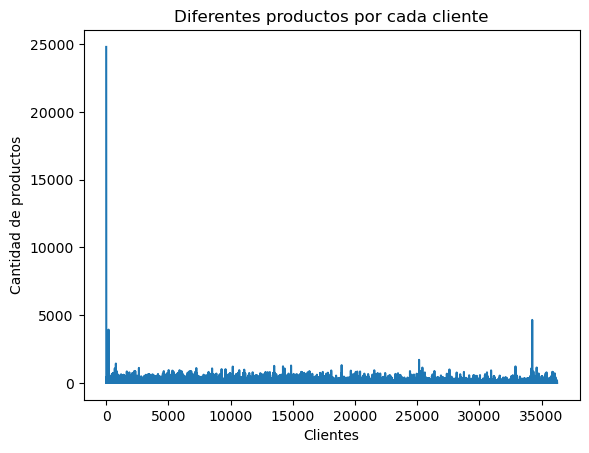

In [12]:
L = list(prdoXcliente['Cantidad'])
plt.plot(L)
plt.title('Diferentes productos por cada cliente')
plt.xlabel('Clientes')
plt.ylabel('Cantidad de productos')
plt.show()

In [13]:
#Eliminando los clientes que compraron demasiados productos
df = df[(df['CodCliente'] != 0) & (df['CodCliente'] != 123456) & (df['CodCliente'] != 4904910) & (df['CodCliente'] != 9109926)]

print('Nro de clientes', len(df['CodCliente'].unique()))
print('Nro de productos', len(df['codigosap'].unique()))

Nro de clientes 36245
Nro de productos 24839


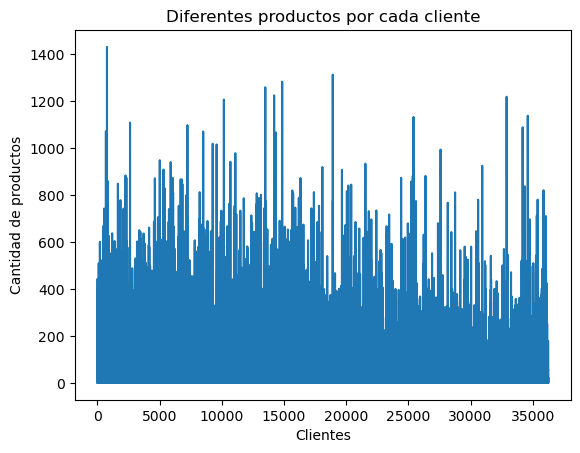

In [14]:
L = list(df.groupby('CodCliente')['codigosap'].nunique().reset_index()['codigosap'])
plt.plot(L)
plt.title('Diferentes productos por cada cliente')
plt.xlabel('Clientes')
plt.ylabel('Cantidad de productos')
plt.show()

## 2.2 Eliminando devoluciones

In [16]:
nevativos = df[df['ImporteLinea'] < 0].shape[0]

print(f"Cantidad de Devoluciones: {nevativos}")
print(f"Porcentaje de la data: {nevativos*100/df.shape[0]}%")

Cantidad de Devoluciones: 1529
Porcentaje de la data: 0.052706980900010476%


In [17]:
#Elimnando los registros de devoluciones
df = df[df['ImporteLinea'] >= 0]

In [18]:
df.shape

(2899415, 9)

# 3. Modelo Item Based Collaborative Filtering

In [ ]:
# Crear una matriz de usuarios y productos
user_product_matrix = df.pivot_table(index='CodCliente', columns='codigosap', values='ImporteLinea', fill_value=0)

# Calcular la similitud del coseno entre todos los productos
product_similarity = cosine_similarity(user_product_matrix.T)
product_similarity_df = pd.DataFrame(product_similarity, index=user_product_matrix.columns, columns=user_product_matrix.columns)

In [ ]:
# Función mejorada para obtener recomendaciones basadas en ítems
def get_item_based_recommendations(user_id, user_product_matrix, product_similarity_df, data, num_recommendations=10):
    # Obtener los productos que el usuario ha comprado
    user_products = user_product_matrix.loc[user_id]
    user_products = user_products[user_products > 0].index.tolist()
    
    # Crear una lista de productos recomendados
    recommendations = pd.Series(dtype=float)
    for product in user_products:
        similar_products = product_similarity_df[product].sort_values(ascending=False)
        similar_products = similar_products.drop(user_products)  # Eliminar los productos que el usuario ya ha comprado
        recommendations = pd.concat([recommendations, similar_products])
    
    # Ordenar las recomendaciones por similitud y devolver las principales
    recommendations = recommendations.groupby(recommendations.index).mean()
    recommendations = recommendations.sort_values(ascending=False).head(num_recommendations)
    
    # Añadir información adicional sobre los productos recomendados
    recommendations = recommendations.reset_index()
    recommendations.columns = ['codigosap', 'similarity']
    recommendations = recommendations.merge(data[['codigosap', 'descripcion', 'Categoria', 'Subcategoria']].drop_duplicates(), on='codigosap', how='left')
    
    return recommendations

In [22]:
# Probar la función de recomendación con un usuario específico
example_user_id = 647917
recommended_items = get_item_based_recommendations(example_user_id, user_product_matrix, product_similarity_df, data)
print(recommended_items)

    codigosap  similarity                               descripcion  \
0      103817    0.116592  FILETE DE POLLO SOFIA EN BANDEJA X KILO    
1      103817    0.116592                  FILETE DE POLLO SOFIA EN   
2      103817    0.116592   FILETE DE POLLO SOFIA EN BANDEJA X KILO   
3      100460    0.113161  PLATANO POR KILO                           
4      100460    0.113161                          PLATANO POR KILO   
5      101588    0.110890  PAPAS RICAPAPA ROJA GOURMET POR KILO       
6      101588    0.110890      PAPAS RICAPAPA ROJA GOURMET POR KILO   
7      101588    0.110890                 PAPAS RICAPAPA ROJA GOURM   
8      200037    0.100598  PAN KETAL KG FRANCES                       
9      200037    0.100598                      PAN KETAL KG FRANCES   
10     100519    0.098909  COLIFLOR POR KILO                          
11     100519    0.098909                         COLIFLOR POR KILO   
12     100489    0.098600  AJO POR KILO                               
13    